# Set up High-level model

This is what the model should do:

<details> 
  <summary> Image of HL model graph </summary>
  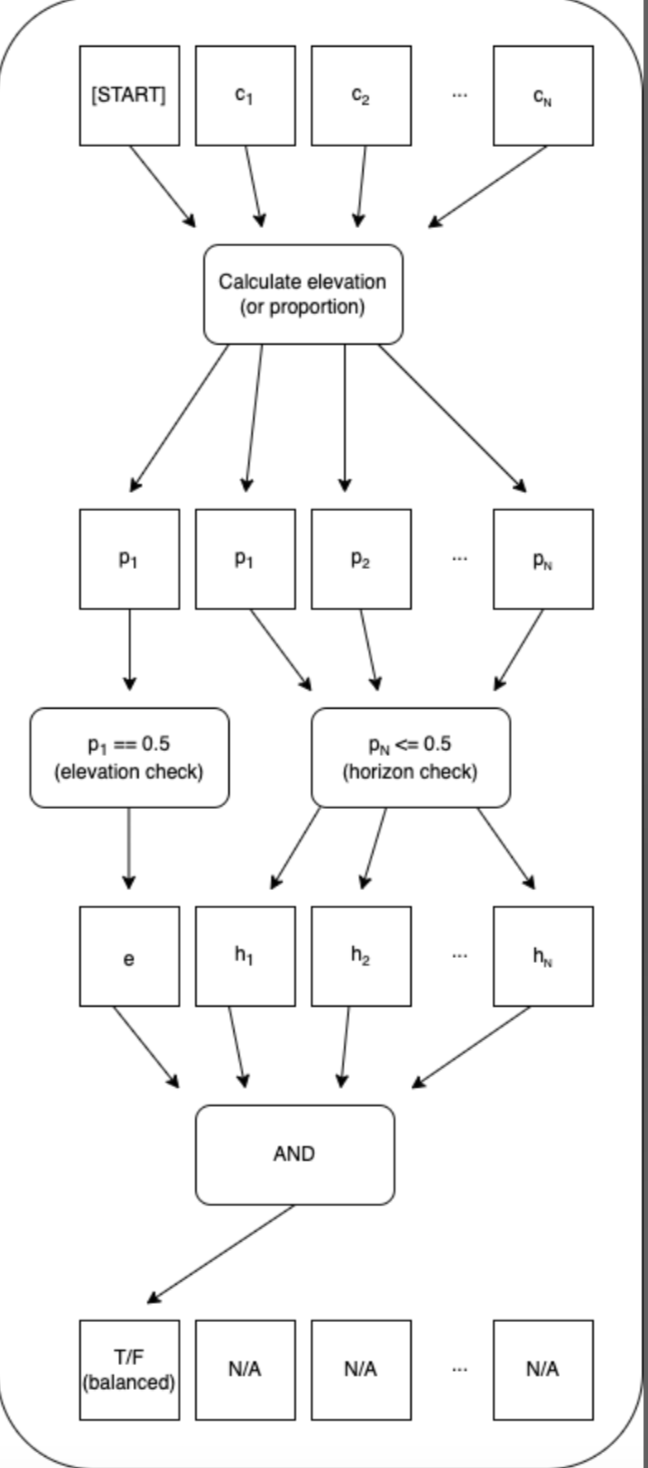
</details>

In [10]:
from jaxtyping import Float, Int, Bool
import torch as t
from transformer_lens.hook_points import HookedRootModule, HookPoint

In [15]:
class ElevationHead(t.nn.Module):
    """ Calculates the elevation at each position in the context"""
    
    def forward(self, tokens: Int[t.Tensor, "batch seq"]) -> Int[t.Tensor, "batch seq"]:
        """ Vocabulary:
                0 - [START]
                1 - (
                2 - )
                3 - [PAD]
        """
        #tok_clone is 1 for ( and -1 for )
        tok_clone = tokens.clone()
        tok_clone[tok_clone == 3] = 0
        tok_clone[tok_clone == 2] = -1

        #we'll count left to right.
        elevation = t.cumsum(tok_clone, dim=1).to(int)

        return elevation
        
#quick check.
tokens = [[0, 1, 2, 1, 2, 1, 2, 3, 3, 3, 3],
          [0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3],
          [0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1],
          [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
         ]
head = ElevationHead()
elevations = head(t.Tensor(tokens))   
elevations

tensor([[ 0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  1,  2,  3,  4,  5,  4,  3,  2,  2,  2],
        [ 0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0],
        [ 0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0]])

In [23]:
class CheckElevation(t.nn.Module):
    """ Checks if the elevation in token position -1 is 0.
        Returns 1 if so and 0 if false.
    """

    def forward(self, elevations: Int[t.Tensor, "batch seq"]) -> Bool[t.Tensor, "batch seq"]:
        elevation_bool = t.ones(elevations.shape, dtype=t.bool)
        elevation_bool[elevations[:,-1].nonzero(), -1] = 0
        return elevation_bool

class CheckHorizon(t.nn.Module):
    """ Checks if the horizon is ever violated (elevation drops below 0)
    """

    def forward(self, elevations: Int[t.Tensor, "batch seq"]) -> Bool[t.Tensor, "batch seq"]:
        horizon_bool = t.ones(elevations.shape, dtype=t.bool)
        horizon_bool[elevations < 0] = 0
        return horizon_bool

check_ele = CheckElevation()
check_hor = CheckHorizon()
ele_check = check_ele(elevations)
hor_check = check_hor(elevations)
print(ele_check)
print(hor_check)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]])
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True, False,  True, False,  True, False,  True, False,  True, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]])


In [25]:
class BalanceCheckHead(t.nn.Module):
    """ Checks to see if the balance has been violated previously in the sequence. """
    def forward(
        self, 
        horizon_check: Bool[t.Tensor, "batch seq"], 
        elevation_check: Bool[t.Tensor, "batch seq"]
    ) -> Bool[t.Tensor, "batch seq"]:
        both_checks = horizon_check*elevation_check
        return t.cumprod(both_checks, dim=1).bool()

bchead = BalanceCheckHead()
bchead(hor_check, ele_check)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [ True, False, False, False, False, False, False, False, False, False,
         False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]])

In [27]:
class HighLevelParensBalanceChecker(HookedRootModule):
    """
    Components:
    - Elevation Calculation Head
    - Elevation Check method
    - Horizon Check method
    - Balance Check Head
    """
    def __init__(self):
        super().__init__()
        self.input_hook = HookPoint()
        self.elevation_head = ElevationHead()
        self.elevation_hook = HookPoint()
        self.elevation_checker = CheckElevation()
        self.elevation_check_hook = HookPoint()
        self.horizon_checker = CheckHorizon()
        self.horizon_check_hook = HookPoint()
        self.balance_check_head = BalanceCheckHead()
        self.balance_check_hook = HookPoint()
        self.setup()

    def forward(self, tokens: Int[t.Tensor, "batch seq"]) -> Bool[t.Tensor, "batch seq"]:
        tokens = self.input_hook(tokens)
        elevation = self.elevation_hook(self.elevation_head(tokens))
        ele_check = self.elevation_check_hook(self.elevation_checker(elevation))
        hor_check = self.horizon_check_hook(self.horizon_checker(elevation))
        balance = self.balance_check_hook(self.balance_check_head(hor_check, ele_check))
        return balance

balance_checker = HighLevelParensBalanceChecker()
balanced = balance_checker(t.Tensor(tokens).to(int))
print(balanced)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [ True, False, False, False, False, False, False, False, False, False,
         False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]])


# Generate Correspondence

In [49]:
from iit.utils.correspondence import Correspondence, HLNode, LLNode

# maps elevation calculation to layer 0 attn
# maps checks to layer 0 mlp
# maps global check to layer 1 attn
corr = {
    'input_hook' : ['blocks.0.hook_resid_pre'],
    'elevation_hook' : ['blocks.0.attn.hook_z'],
    'elevation_check_hook' : ['blocks.0.mlp.hook_post'],
    'horizon_check_hook' : ['blocks.0.mlp.hook_post'], #mlp does two tasks
    'balance_check_hook' : ['blocks.1.attn.hook_z'],
}
corr_obj = Correspondence.make_corr_from_dict(corr, suffixes={})
for k, i in corr_obj.items():
    print(f'{str(k):>20s}, {i}')

          input_hook, {LLNode(name='blocks.0.hook_resid_pre', index=[:], subspace=None)}
      elevation_hook, {LLNode(name='blocks.0.attn.hook_z', index=[:], subspace=None)}
elevation_check_hook, {LLNode(name='blocks.0.mlp.hook_post', index=[:], subspace=None)}
  horizon_check_hook, {LLNode(name='blocks.0.mlp.hook_post', index=[:], subspace=None)}
  balance_check_hook, {LLNode(name='blocks.1.attn.hook_z', index=[:], subspace=None)}
